# Inverse Option Pricing Examples

This notebook demonstrates how to use the `inverse_fft_pricer` module to price European inverse (coin-denominated) call and put options on a futures contract under three models:

- **Black (lognormal) model**
- **Heston stochastic volatility model**
- **SVCJ (stochastic volatility with correlated jumps) model**

The Carr–Madan Fast Fourier Transform (FFT) algorithm is used to compute a grid of regular USD call prices, which are then converted to inverse option prices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.inverse_fft_pricer import (
    price_inverse_option,
    FFTParams,
    black76_call_price,
    black76_put_price,
    heston_call_price,
    heston_put_price,
)

# Configure matplotlib for the notebook (no specific colours/styles)
%matplotlib inline


## Common Setup

We will price options with the same spot (futures) price and maturity across all models.  Adjust the FFT grid parameters so that the strike grid covers the strikes we are interested in.


In [2]:
# Current futures price and maturity
F0 = 100.0  # USD per coin
T = 1.0     # 1 year to maturity

# Strike range for examples
K_vals = np.linspace(50, 150, 25)

# FFT parameters: choose a grid that spans our strike range
# The minimum log‑strike b should be low enough so that exp(b) << min(K_vals)
fft_params = FFTParams(N=2**12, alpha=1.5, eta=0.05, b=np.log(1e-3), use_simpson=True)


## Black Model Example

In the Black model (lognormal futures), the characteristic function has a closed form and there is an analytical Black–76 price for comparison.  Here we use the FFT to compute inverse call and put prices and validate the results against the analytic formula.


In [3]:
# Black model parameters
sigma = 0.2  # annual volatility
params_black = {'sigma': sigma}

# Inverse call and put prices via FFT
call_coin_black = price_inverse_option('black', K_vals, T, F0, params_black, option_type='call', fft_params=fft_params)
put_coin_black  = price_inverse_option('black', K_vals, T, F0, params_black, option_type='put',  fft_params=fft_params)

# Analytic Black–76 call and put prices in USD
call_usd_analytic = np.array([black76_call_price(F0, K, T, sigma) for K in K_vals])
put_usd_analytic  = np.array([black76_put_price(F0, K, T, sigma) for K in K_vals])
# Convert to coin units
call_coin_analytic = call_usd_analytic / F0
put_coin_analytic  = put_usd_analytic / F0

# Display the first few results
import pandas as pd
black_df = pd.DataFrame({
    'K': K_vals,
    'Call (coin) FFT': call_coin_black,
    'Put  (coin) FFT': put_coin_black,
    'Call (coin) analytic': call_coin_analytic,
    'Put  (coin) analytic': put_coin_analytic,
})

black_df.head()


,K,Call (coin) FFT,Put (coin) FFT,Call (coin) analytic,Put (coin) analytic
0,50.000000,0.500010,0.000010,0.500009,0.000009
1,54.166667,0.458379,0.000046,0.458378,0.000044
2,58.333333,0.416834,0.000168,0.416831,0.000164
3,62.500000,0.375500,0.000500,0.375497,0.000497
4,66.666667,0.334621,0.001288,0.334617,0.001283


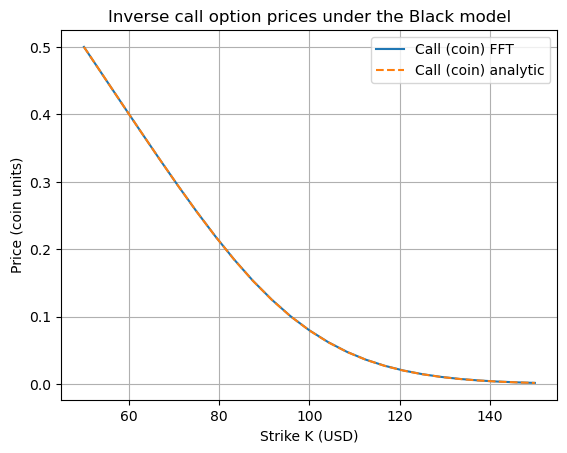

In [4]:
# Plot the inverse call price curves for the Black model
plt.figure()
plt.plot(K_vals, call_coin_black, label='Call (coin) FFT')
plt.plot(K_vals, call_coin_analytic, '--', label='Call (coin) analytic')
plt.title('Inverse call option prices under the Black model')
plt.xlabel('Strike K (USD)')
plt.ylabel('Price (coin units)')
plt.legend()
plt.grid(True)
plt.show()


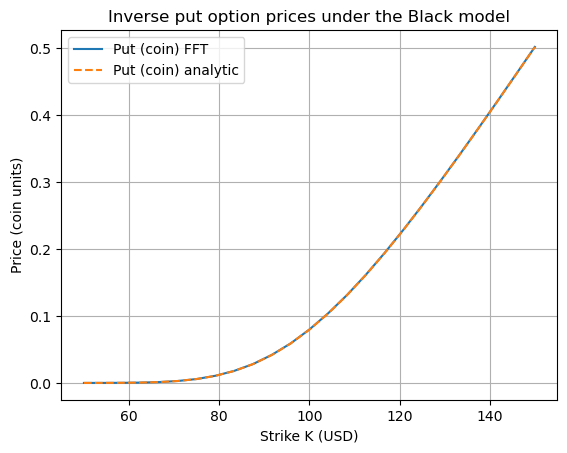

In [5]:
# Plot the inverse put price curves for the Black model
plt.figure()
plt.plot(K_vals, put_coin_black, label='Put (coin) FFT')
plt.plot(K_vals, put_coin_analytic, '--', label='Put (coin) analytic')
plt.title('Inverse put option prices under the Black model')
plt.xlabel('Strike K (USD)')
plt.ylabel('Price (coin units)')
plt.legend()
plt.grid(True)
plt.show()


## Heston Model Example

We next price inverse options under the Heston stochastic volatility model.  There is no closed form for the option price, but the characteristic function has an analytic form that makes FFT pricing possible.  We choose reasonable model parameters and compute call and put prices.


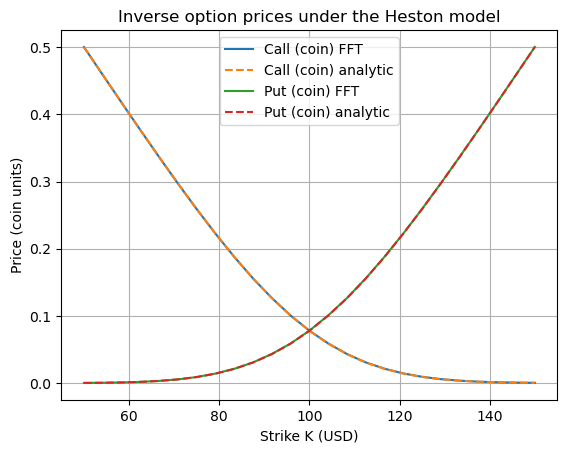

,K,Call (coin) FFT,Put (coin) FFT,Call (coin) analytic,Put (coin) analytic
0,50.000000,0.500199,0.000199,0.500197,0.000197
1,54.166667,0.458777,0.000444,0.458773,0.000440
2,58.333333,0.417581,0.000915,0.417574,0.000908
3,62.500000,0.376752,0.001752,0.376749,0.001749
4,66.666667,0.336510,0.003177,0.336505,0.003172


In [6]:
# Heston model parameters
params_heston = {
    'kappa': 2.0,   # mean reversion speed
    'theta': 0.04,  # long‑run variance
    'sigma_v': 0.2, # vol of vol
    'rho': -0.7,    # correlation between asset and variance
    'v0': 0.04,     # initial variance
}

# Inverse call and put prices via FFT for the Heston model
call_coin_heston = price_inverse_option('heston', K_vals, T, F0, params_heston, option_type='call', fft_params=fft_params)
put_coin_heston  = price_inverse_option('heston', K_vals, T, F0, params_heston, option_type='put',  fft_params=fft_params)

# Analytic Heston call and put prices (semi‑analytic) in USD
call_usd_heston_analytic = np.array([
    heston_call_price(F0, K, T, **params_heston, n=2000) for K in K_vals
])
put_usd_heston_analytic  = np.array([
    heston_put_price(F0, K, T, **params_heston, n=2000) for K in K_vals
])
# Convert to coin units
call_coin_heston_analytic = call_usd_heston_analytic / F0
put_coin_heston_analytic  = put_usd_heston_analytic / F0

# Plot the inverse call and put prices vs analytic benchmarks
plt.figure()
plt.plot(K_vals, call_coin_heston, label='Call (coin) FFT')
plt.plot(K_vals, call_coin_heston_analytic, '--', label='Call (coin) analytic')
plt.plot(K_vals, put_coin_heston, label='Put (coin) FFT')
plt.plot(K_vals, put_coin_heston_analytic, '--', label='Put (coin) analytic')
plt.title('Inverse option prices under the Heston model')
plt.xlabel('Strike K (USD)')
plt.ylabel('Price (coin units)')
plt.legend()
plt.grid(True)
plt.show()

# Display the first few results in a DataFrame
import pandas as pd
heston_df = pd.DataFrame({
    'K': K_vals,
    'Call (coin) FFT': call_coin_heston,
    'Put  (coin) FFT': put_coin_heston,
    'Call (coin) analytic': call_coin_heston_analytic,
    'Put  (coin) analytic': put_coin_heston_analytic,
})

heston_df.head()


## SVCJ Model Example

Finally, we price inverse options under the SVCJ model, which includes jumps in both returns and volatility. The characteristic function requires a numerical integration over time, implemented with Gauss–Legendre quadrature.  Here we choose illustrative parameters and compute the option prices.


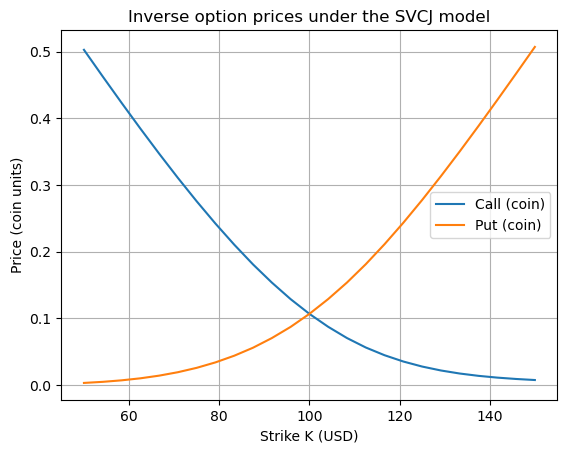

,K,Call (coin),Put (coin)
0,50.000000,0.502917,0.002917
1,54.166667,0.462871,0.004538
2,58.333333,0.423460,0.006794
3,62.500000,0.384824,0.009824
4,66.666667,0.347165,0.013832


In [7]:
# SVCJ model parameters
params_svcj = {
    'kappa': 2.0,
    'theta': 0.04,
    'sigma_v': 0.2,
    'rho': -0.7,
    'v0': 0.04,
    'lam': 0.5,     # jump intensity
    'ell_y': -0.1,  # mean of log‑return jump
    'sigma_y': 0.25,# std of log‑return jump
    'ell_v': 0.05,  # mean of variance jump
    'rho_j': -0.5,  # correlation between return and variance jumps
}

# Inverse call and put prices via FFT for the SVCJ model
call_coin_svcj = price_inverse_option('svcj', K_vals, T, F0, params_svcj, option_type='call', fft_params=fft_params)
put_coin_svcj  = price_inverse_option('svcj', K_vals, T, F0, params_svcj, option_type='put',  fft_params=fft_params)

# Plot the inverse call and put prices
plt.figure()
plt.plot(K_vals, call_coin_svcj, label='Call (coin)')
plt.plot(K_vals, put_coin_svcj, label='Put (coin)')
plt.title('Inverse option prices under the SVCJ model')
plt.xlabel('Strike K (USD)')
plt.ylabel('Price (coin units)')
plt.legend()
plt.grid(True)
plt.show()

# Display a table of the first few results
svcj_df = pd.DataFrame({
    'K': K_vals,
    'Call (coin)': call_coin_svcj,
    'Put  (coin)': put_coin_svcj,
})
svcj_df.head()
